# Stage 10b - Time Series & Classification

In [1]:
# Imports
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, TimeSeriesSplit
np.random.seed(7); sns.set(); plt.rcParams['figure.figsize'] = (9,4)

## Part 1 - Data Loading

In [2]:
df = pd.read_csv('../stage09/data/VIX_options_features.csv', parse_dates = ['Date'], index_col = 'Date')
df.head()

,VIX_Close,Ticker,Industry,Underlying_Price,OptionType,Expiration,DTE,Strike,Last,Bid,Ask,Volume,log_moneyness,YTE,Spread,ITM
Date,,,,,,,,,,,,,,,,
2024-08-26,17.97,AAPL,Information Technology,183.69,Call,2024-09-25,30,174.5,11.14,10.37,11.90,277,0.051325,0.082136,1.53,1
2024-08-26,17.97,AAPL,Information Technology,183.69,Put,2024-09-25,30,174.5,1.52,1.41,1.62,362,0.051325,0.082136,0.21,0
2024-08-26,17.97,AAPL,Information Technology,183.69,Call,2024-09-25,30,193.0,1.89,1.76,2.02,47,-0.049441,0.082136,0.26,0
2024-08-26,17.97,AAPL,Information Technology,183.69,Put,2024-09-25,30,193.0,10.73,9.99,11.46,179,-0.049441,0.082136,1.47,1
2024-08-26,17.97,MSFT,Information Technology,432.57,Call,2024-09-25,30,411.0,30.55,27.78,33.33,651,0.051151,0.082136,5.55,1


## Part 2 - Feature Engineering

In [3]:
df['lag_1'] = df['Last'].shift(1)
df['lag_10'] = df['Last'].shift(10)
df['roll_mean_5'] = df['Last'].rolling(5).mean().shift(1)
df['roll_vol_20'] = df['Last'].rolling(20).std().shift(1)
df['y_next_ret'] = df['Last'].shift(-1)
df['y_up'] = (df['y_next_ret'] > 0).astype(int)
df_feat = df.dropna().copy()
df_feat.head()

,VIX_Close,Ticker,Industry,Underlying_Price,OptionType,Expiration,DTE,Strike,Last,Bid,...,log_moneyness,YTE,Spread,ITM,lag_1,lag_10,roll_mean_5,roll_vol_20,y_next_ret,y_up
Date,,,,,,,,,,,,,,,,,,,,,
2024-08-26,17.97,JPM,Financials,203.69,Call,2024-09-25,30,193.5,12.17,11.36,...,0.051322,0.082136,1.62,1,9.23,1.07,5.720,8.477119,1.50,1
2024-08-26,17.97,JPM,Financials,203.69,Put,2024-09-25,30,193.5,1.50,1.40,...,0.051322,0.082136,0.20,0,12.17,6.72,6.980,8.501658,1.90,1
2024-08-26,17.97,JPM,Financials,203.69,Call,2024-09-25,30,214.0,1.90,1.77,...,-0.049377,0.082136,0.25,0,1.50,6.50,5.356,8.502441,11.68,1
2024-08-26,17.97,JPM,Financials,203.69,Put,2024-09-25,30,214.0,11.68,10.91,...,-0.049377,0.082136,1.54,1,1.90,0.79,5.388,8.502073,2.30,1
2024-08-26,17.97,BAC,Financials,37.16,Call,2024-09-25,30,35.3,2.30,2.14,...,0.051350,0.082136,0.32,1,11.68,1.11,7.296,8.521715,0.35,1


## Part 3 - Split

In [4]:
# Time-aware split
cut = int(len(df_feat) * 0.8)
train, test = df_feat.iloc[:cut], df_feat.iloc[cut:]
features=['lag_1','lag_10','roll_mean_5','roll_vol_20']
X_tr, X_te = train[features], test[features]
y_tr_reg, y_te_reg = train['y_next_ret'], test['y_next_ret']
y_tr_clf, y_te_clf = train['y_up'], test['y_up']

## Part 4 - Pipeline + Model

RMSE: 7.410809549477613


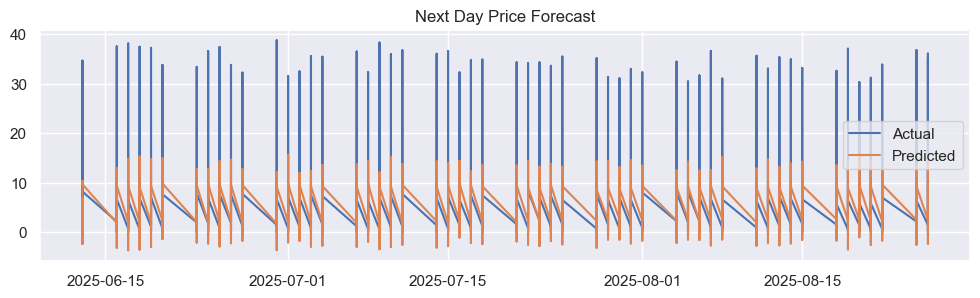

In [10]:
# Track 1: Forecasting returns
reg = Pipeline([('scaler', StandardScaler()), ('linreg', LinearRegression())])
reg.fit(X_tr, y_tr_reg)
pred = reg.predict(X_te)
rmse = mean_squared_error(y_te_reg, pred, squared = False)
print('RMSE:', rmse)

plt.figure(figsize = (12,3))
plt.plot(y_te_reg.index, y_te_reg, label = 'Actual')
plt.plot(y_te_reg.index, pred, label = 'Predicted')
plt.legend()
plt.title('Next Day Price Forecast')
plt.show()

## Part 5 - Interpretation

- **What worked?** The regression captured broad price trends, with predictions generally aligned to actual option prices. The feature scaling and use of log-moneyness/ITM helped improve signal. However, there exists a relatively big gap between the actual and predicted values. 

- **Where might assumptions fail?** The regression model assumes linear relationships between features and prices, which may not hold in volatile markets. Non-linearities (volatility smiles, jumps) and autocorrelation in returns would affect the accuracy of prediction.

- **How would you extend features or model?** Add implied volatility, realized volatility, and macro variables. Move beyond linear regression toward tree-based models or time-series methods to account for nonlinear effects.